# NYC Taxi - Fare Prediction project

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from geopy.distance import geodesic
from pyproj import Geod
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians
import dask.dataframe as dd

In [2]:
train_data = pd.read_csv('train.csv')

In [3]:
# Visually inspecting the data
train_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
# Checking columns names
train_data.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [5]:
train_data.shape

(55423856, 8)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.3+ GB


In [7]:
#Counting the values in passenger_count column
train_data.passenger_count.value_counts(dropna=False)

1      38337524
2       8175243
5       3929346
3       2432712
4       1178852
6       1174647
0        195416
208          64
9            23
7            15
8             9
129           2
51            1
49            1
34            1
Name: passenger_count, dtype: int64

In [8]:
#Counting the values in pickup_datetime column 
train_data.pickup_datetime.value_counts(dropna=False)

2009-11-01 01:17:00 UTC    62
2013-11-03 01:29:00 UTC    62
2010-11-07 01:01:00 UTC    60
2010-11-07 01:10:00 UTC    59
2009-11-01 01:05:00 UTC    59
2010-11-07 01:05:00 UTC    58
2010-11-07 01:00:00 UTC    57
2014-03-13 20:11:00 UTC    57
2009-11-01 01:45:00 UTC    56
2010-11-07 01:35:00 UTC    55
2013-11-03 01:09:00 UTC    55
2013-04-26 20:15:00 UTC    55
2013-11-03 01:11:00 UTC    55
2010-04-16 20:37:00 UTC    55
2009-10-21 19:01:00 UTC    54
2009-11-01 01:41:00 UTC    54
2013-11-23 23:14:00 UTC    54
2010-02-23 18:38:00 UTC    54
2013-04-19 18:34:00 UTC    54
2009-11-01 01:31:00 UTC    54
2013-04-20 00:49:00 UTC    53
2013-04-19 19:17:00 UTC    53
2013-04-27 23:58:00 UTC    53
2013-04-20 23:54:00 UTC    53
2012-03-09 22:06:00 UTC    53
2009-11-01 01:38:00 UTC    53
2013-04-20 22:33:00 UTC    53
2009-11-01 01:02:00 UTC    53
2012-09-22 21:51:00 UTC    53
2012-06-06 19:47:00 UTC    53
                           ..
2009-07-10 17:40:23 UTC     1
2012-12-20 11:10:26 UTC     1
2015-05-29

In [9]:
#Counting the values in fare_amount column 
train_data.fare_amount.value_counts(dropna=False)

 6.50      2691783
 4.50      2270305
 8.50      2080476
 5.30      1623420
 5.70      1620795
 6.10      1578275
 4.90      1571360
 6.90      1445389
 10.50     1408721
 7.30      1361582
 7.70      1268537
 4.10      1175806
 8.10      1175770
 7.00      1159454
 6.00      1155132
 5.50      1122703
 7.50      1113201
 8.00      1056206
 5.00      1028036
 8.90       975650
 9.00       946448
 12.50      938777
 9.30       889903
 9.50       875406
 9.70       809765
 3.70       808442
 10.00      803013
 10.10      736606
 11.00      681711
 14.50      635346
            ...   
 310.10          1
 71.74           1
 71.01           1
 64.74           1
 70.51           1
-67.50           1
-67.00           1
 279.65          1
 275.60          1
 262.60          1
 269.60          1
 269.35          1
 269.10          1
-64.00           1
 306.60          1
 65.01           1
 319.60          1
 293.60          1
 290.90          1
 479.35          1
 476.10          1
 459.90     

In [10]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134505e+01,-7.250968e+01,3.991979e+01,-7.251121e+01,3.992068e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


In [11]:
#Fare amount has some negative values
train_data[train_data.fare_amount<0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,2010-03-09 23:37:10.0000005,-2.90,2010-03-09 23:37:10 UTC,-73.789450,40.643498,-73.788665,40.641952,1
2486,2015-03-22 05:14:27.0000001,-2.50,2015-03-22 05:14:27 UTC,-74.000031,40.720631,-73.999809,40.720539,1
13032,2013-08-30 08:57:10.0000002,-3.00,2013-08-30 08:57:10 UTC,-73.995062,40.740755,-73.995885,40.741357,4
28839,2013-08-11 13:39:10.0000001,-2.50,2013-08-11 13:39:10 UTC,-73.785260,40.648442,0.000000,0.000000,1
36722,2015-04-30 15:19:45.0000003,-2.50,2015-04-30 15:19:45 UTC,-73.952187,40.790112,-73.950043,40.792839,1
42337,2015-03-09 10:29:46.0000004,-5.00,2015-03-09 10:29:46 UTC,-73.990974,40.755985,-73.980820,40.759869,1
56748,2015-06-26 01:13:18.0000002,-5.00,2015-06-26 01:13:18 UTC,-73.979797,40.743240,-73.981216,40.737240,6
58937,2010-02-19 23:47:10.0000002,-44.90,2010-02-19 23:47:10 UTC,-73.871120,40.773902,-73.676533,40.786890,1
97838,2015-06-07 02:54:14.0000004,-3.00,2015-06-07 02:54:14 UTC,-73.913246,40.766212,-73.914963,40.764065,5
102938,2010-02-10 12:33:10.0000004,-2.90,2010-02-10 12:33:10 UTC,-73.970775,40.783425,-73.973443,40.779775,1


In [12]:
# Removing negative fare_amount
train_data = train_data[train_data.fare_amount>=0]

In [13]:
#Remove missing data
print(train_data.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64


In [14]:
# Dropping Null Values
print('Old size: %d' % len(train_data))
train_data = train_data.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_data))

Old size: 55421402
New size: 55421026


In [15]:
# Removing passenger_count = 0 
print('Old size: %d' % len(train_data))
train_data = train_data[train_data.passenger_count>=1]
print('New size: %d' % len(train_data))

Old size: 55421026
New size: 55225987


In [16]:
# Removing passenger_count greater than 6
print('Old size: %d' % len(train_data))
train_data = train_data[train_data.passenger_count<=6]
print('New size: %d' % len(train_data))

Old size: 55225987
New size: 55225871


In [17]:
# Making sure the data has no null values before we export it
print(train_data.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [18]:
train_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55225871 entries, 0 to 55423855
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.7+ GB


In [22]:
# Exporting cleaned data to a CSV
train_data.to_csv('train_cleaned.csv')

In [2]:
# Importing the cleaned training data
train_data = pd.read_csv('train_cleaned.csv')
#train_data = dd.read_csv('train_cleaned.csv')

In [3]:
train_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_latitude_radians,pickup_longitude_radians
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.710721,-1.288826
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.710546,-1.291824
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.711418,-1.291242
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.710927,-1.291319
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.711536,-1.290987


In [4]:
lat1 = train_data.loc[:,['pickup_latitude']]
long1 = train_data.loc[:,['pickup_longitude']]
lat2 = train_data.loc[:,['dropoff_latitude']]
long2 = train_data.loc[:,['dropoff_longitude']]

In [5]:
# To get the distance between the two rides we need to convert Latitude and Longitude in Radians
train_data['pickup_latitude_radians'] = train_data['pickup_latitude'].apply(lambda x: radians(x))
train_data['pickup_longitude_radians'] = train_data['pickup_longitude'].apply(lambda x: radians(x))
train_data['dropoff_latitude_radians'] = train_data['dropoff_latitude'].apply(lambda x: radians(x))
train_data['dropoff_longitude_radians'] = train_data['dropoff_longitude'].apply(lambda x: radians(x))

In [7]:
print('New size: %d' % len(train_data))

New size: 55225871


In [6]:
train_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_latitude_radians,pickup_longitude_radians,dropoff_latitude_radians,dropoff_longitude_radians
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.710721,-1.288826,0.710563,-1.288779
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.710546,-1.291824,0.711780,-1.291182
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.711418,-1.291242,0.711231,-1.291391
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.710927,-1.291319,0.711363,-1.291396
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.711536,-1.290987,0.711811,-1.290787


In [12]:
#checking difference between latitude and longitude in radians in training data
lat1 = train_data['pickup_latitude_radians']
long1 = train_data['pickup_longitude_radians']
lat2 = train_data['dropoff_latitude_radians']
long2 = train_data['dropoff_longitude_radians']

train_data['dlon'] = long2 - long1
train_data['dlat'] = lat2 - lat1

In [14]:
#Exporting training data with new features to a new csv
train_data.to_csv('train_cleaned.csv')

In [2]:
#Importing the cleaned data
train_data = pd.read_csv('train_cleaned.csv')

In [ ]:
# dropping the Unnamed column
train_data = train_data.drop(['Unnamed: 0'], axis=1)

In [3]:
train_data.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'pickup_latitude_radians',
       'pickup_longitude_radians', 'dropoff_latitude_radians',
       'dropoff_longitude_radians', 'dlon', 'dlat'],
      dtype='object')

In [6]:
train_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_latitude_radians,pickup_longitude_radians,dropoff_latitude_radians,dropoff_longitude_radians,dlon,dlat
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.710721,-1.288826,0.710563,-1.288779,0.000047,-0.000158
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.710546,-1.291824,0.711780,-1.291182,0.000642,0.001234
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.711418,-1.291242,0.711231,-1.291391,-0.000148,-0.000187
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.710927,-1.291319,0.711363,-1.291396,-0.000077,0.000435
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.711536,-1.290987,0.711811,-1.290787,0.000200,0.000275


In [7]:
dlon = train_data['dlon']
dlat = train_data['dlat']
lat1 = train_data['pickup_latitude_radians']
long1 = train_data['pickup_longitude_radians']
lat2 = train_data['dropoff_latitude_radians']
long2 = train_data['dropoff_longitude_radians']

R = 6373.0
def distance(dlat,dlon,lat1,lat2,R):
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    dist = R * c
    return dist

#result = train_data.apply(lambda dist: distance(dlat,dlon,lat1,lat2,R), axis=1)

#print "Result", distance

In [ ]:
#Problem
train_data['result'] = train_data.apply(lambda dist: distance(dlat,dlon,lat1,lat2,R), axis=1)

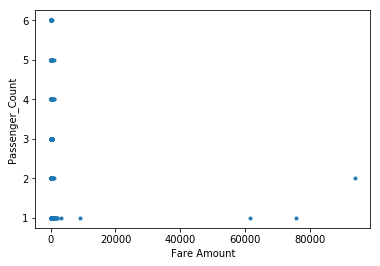

In [8]:
# Plot the histogram with default number of bins; label your axes
_ = plt.plot(train_data['fare_amount'], train_data['passenger_count'], marker='.',linestyle='none')
_ = plt.xlabel('Fare Amount')
_ = plt.ylabel('Passenger_Count')
# Show the plot
plt.show()

In [29]:
#Fare amount has some extreme values
outliers = train_data[train_data.fare_amount>1000]
outliers

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_latitude_radians,pickup_longitude_radians,dropoff_latitude_radians,dropoff_longitude_radians,dlon,dlat
1140576,2015-03-09 15:12:00.0000002,1273.31,2015-03-09 15:12:00 UTC,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
18526273,2010-03-21 10:03:32.0000004,2010.90,2010-03-21 10:03:32 UTC,-73.986265,40.774846,-73.971539,40.743949,1,0.711655,-1.291304,0.711116,-1.291047,2.570172e-04,-5.392544e-04
18791985,2013-08-20 11:52:52.0000001,61550.86,2013-08-20 11:52:52 UTC,-73.967711,40.755965,-73.945572,40.747666,1,0.711326,-1.290980,0.711181,-1.290594,3.863984e-04,-1.448449e-04
22622356,2015-03-09 15:28:56.0000007,3130.30,2015-03-09 15:28:56 UTC,-74.005417,40.664413,-74.005417,40.664413,1,0.709728,-1.291638,0.709728,-1.291638,0.000000e+00,0.000000e+00
27726013,2015-03-11 13:19:00.0000006,1097.48,2015-03-11 13:19:00 UTC,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
30712825,2010-03-20 12:24:52.0000001,2004.50,2010-03-20 12:24:52 UTC,-73.963134,40.777854,-73.975432,40.782148,1,0.711708,-1.290900,0.711783,-1.291115,-2.146406e-04,7.494444e-05
37743752,2010-03-21 14:43:02.0000004,2023.70,2010-03-21 14:43:02 UTC,-73.790056,40.647064,-73.917979,40.656940,1,0.709425,-1.287879,0.709597,-1.290112,-2.232678e-03,1.723687e-04
39233433,2010-02-19 17:10:00.000000117,9000.41,2010-02-19 17:10:00 UTC,-73.993745,40.746105,-73.989807,40.738977,1,0.711154,-1.291434,0.711029,-1.291366,6.873107e-05,-1.244071e-04
40885293,2015-02-24 08:57:37.0000004,93963.36,2015-02-24 08:57:37 UTC,-73.994461,40.712353,-74.012543,40.702904,2,0.710565,-1.291447,0.710400,-1.291763,-3.155846e-04,-1.649163e-04
41038490,2015-05-03 09:35:20.0000001,75747.02,2015-05-03 09:35:20 UTC,-73.967949,40.792355,-73.990898,40.738976,1,0.711961,-1.290984,0.711029,-1.291385,-4.005394e-04,-9.316403e-04


In [30]:
#Fare amount has some 0 values
nulls = train_data[train_data.fare_amount==0]
nulls

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_latitude_radians,pickup_longitude_radians,dropoff_latitude_radians,dropoff_longitude_radians,dlon,dlat
9962,2010-02-15 14:26:01.0000003,0.0,2010-02-15 14:26:01 UTC,-73.987115,40.738808,-74.005911,40.713960,1,0.711026,-1.291319,0.710593,-1.291647,-3.280521e-04,-4.336794e-04
27786,2015-05-15 21:40:28.00000010,0.0,2015-05-15 21:40:28 UTC,-74.077927,40.805714,-74.077919,40.805721,1,0.712194,-1.292904,0.712194,-1.292904,1.331581e-07,1.331581e-07
47136,2010-03-18 19:13:39.0000002,0.0,2010-03-18 19:13:39 UTC,-73.942346,40.806269,-73.942463,40.806129,1,0.712204,-1.290537,0.712201,-1.290539,-2.042035e-06,-2.443461e-06
104653,2013-08-21 21:41:00.000000215,0.0,2013-08-21 21:41:00 UTC,0.000000,0.000000,0.000000,0.000000,2,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
174709,2014-06-29 16:04:29.0000002,0.0,2014-06-29 16:04:29 UTC,-73.484480,40.813401,-73.484442,40.813323,2,0.712328,-1.282546,0.712327,-1.282545,6.632251e-07,-1.361357e-06
210689,2015-04-15 14:02:39.0000003,0.0,2015-04-15 14:02:39 UTC,-73.937378,40.758450,-73.937447,40.758450,1,0.711369,-1.290451,0.711369,-1.290452,-1.198422e-06,0.000000e+00
210733,2010-03-08 18:22:00.00000076,0.0,2010-03-08 18:22:00 UTC,-73.937353,40.758227,-73.937358,40.758230,1,0.711365,-1.290450,0.711365,-1.290450,-8.726646e-08,5.235988e-08
265503,2010-02-20 09:51:27.0000004,0.0,2010-02-20 09:51:27 UTC,-73.877376,40.772415,-73.877403,40.772391,1,0.711613,-1.289403,0.711612,-1.289404,-4.712389e-07,-4.188790e-07
330391,2013-08-05 06:45:54.0000005,0.0,2013-08-05 06:45:54 UTC,-73.982354,40.679971,-73.982354,40.679971,1,0.709999,-1.291236,0.709999,-1.291236,0.000000e+00,0.000000e+00
385337,2015-05-08 07:02:38.0000001,0.0,2015-05-08 07:02:38 UTC,-73.999496,40.748787,-74.002556,40.744659,1,0.711200,-1.291535,0.711128,-1.291588,-5.339638e-05,-7.203851e-05


In [31]:
#pickup_longitude has some 0 values
nulls1 = train_data[train_data.pickup_longitude==0]
nulls1

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_latitude_radians,pickup_longitude_radians,dropoff_latitude_radians,dropoff_longitude_radians,dlon,dlat
11,2012-12-24 11:24:00.00000098,5.50,2012-12-24 11:24:00 UTC,0.0,0.0,0.000000,0.000000,3,0.0,0.0,0.000000,0.000000,0.000000,0.000000
15,2013-11-23 12:57:00.000000190,5.00,2013-11-23 12:57:00 UTC,0.0,0.0,0.000000,0.000000,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000
26,2011-02-07 20:01:00.000000114,6.50,2011-02-07 20:01:00 UTC,0.0,0.0,0.000000,0.000000,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000
124,2013-01-17 17:22:00.00000043,8.00,2013-01-17 17:22:00 UTC,0.0,0.0,0.000000,0.000000,2,0.0,0.0,0.000000,0.000000,0.000000,0.000000
192,2010-09-05 17:08:00.00000092,3.70,2010-09-05 17:08:00 UTC,0.0,0.0,0.000000,0.000000,5,0.0,0.0,0.000000,0.000000,0.000000,0.000000
233,2011-07-24 01:14:35.0000002,8.50,2011-07-24 01:14:35 UTC,0.0,0.0,0.000000,0.000000,2,0.0,0.0,0.000000,0.000000,0.000000,0.000000
273,2009-10-30 18:13:00.00000021,8.10,2009-10-30 18:13:00 UTC,0.0,0.0,0.000000,0.000000,4,0.0,0.0,0.000000,0.000000,0.000000,0.000000
356,2013-07-04 16:41:27.0000002,8.50,2013-07-04 16:41:27 UTC,0.0,0.0,0.000000,0.000000,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000
375,2014-05-29 05:57:22.0000001,2.50,2014-05-29 05:57:22 UTC,0.0,0.0,0.000000,0.000000,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000
386,2012-11-15 08:39:00.00000095,13.00,2012-11-15 08:39:00 UTC,0.0,0.0,0.000000,0.000000,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [33]:
# Removing 0 fare_amount

print('Old size: %d' % len(train_data))
train_data = train_data[train_data.fare_amount>=1.0]
print('New size: %d' % len(train_data))

Old size: 55225871


MemoryError: 

In [ ]:
# Removing 0 pickup_longitude, pickup_longitude, dropoff_longitude, dropoff_latitude train_data[(train_data) != 0).all(1)]

print('Old size: %d' % len(train_data))
train_data = train_data[(train_data) != 0).all(1)]
print('New size: %d' % len(train_data))

In [ ]:
print('Old size: %d' % len(train_data))
train_data = train_data[(train_data) != 0).all(1)]
print('New size: %d' % len(train_data))

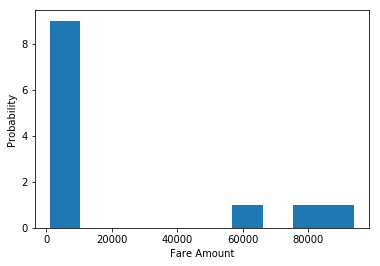

In [28]:
# Plot the histogram with default number of bins; label your axes
_ = plt.hist(outliers['fare_amount'])
_ = plt.xlabel('Fare Amount')
_ = plt.ylabel('Probability')
# Show the plot
plt.show()

In [ ]:
sns.set(style="whitegrid")
ax = sns.barplot(x="fare_amount", y="passenger_count", data=train_data)